In [ ]:
#ML PROJECT SPRING 2022
#Author: Malavika Venkatanarayanan (mv2290@nyu.edu)
#NETID : mv2290
#New York University

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [2]:
#Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#LOAD DATA
data = pd.read_csv('gdrive/MyDrive/Bigmart/Train.csv')
# data.head(6)
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [4]:
# Data Statistics
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
#Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
#Find no of unique values in each column
data.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

## Preprocessing the dataset

In [7]:
#Find no of null values in each column
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# Collect the columns with categorical data
catogorical_columns = []
for x in data.dtypes.index:
    if data.dtypes[x] == 'object':
        catogorical_columns.append(x)
catogorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [9]:
#Removing unecessary columns
catogorical_columns.remove('Item_Identifier')
catogorical_columns.remove('Outlet_Identifier')
catogorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [10]:
#Print contents of each catogorical columns
for column in catogorical_columns:
    print(column)
    print("--------------------------")
    print(data[column].value_counts())
    print()
   

Item_Fat_Content
--------------------------
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type
--------------------------
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Size
--------------------------
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
--------------------------
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
--------------------------

In [11]:
data['Item_Weight'].isna().sum()

1463

In [12]:
data['Item_Weight'].fillna(data['Item_Weight'].mean(),inplace=True)

In [13]:
data['Item_Weight'].isna().sum()

0

In [14]:
data['Outlet_Size'].isna().sum()

2410

In [17]:
#fill the missing values in outlet_type with the mode corresponding to each outlet size
size_modes = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
size_modes

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [18]:
#Fill in the missing values with the mode
missing_rows = data['Outlet_Size'].isnull()
data.loc[missing_rows, 'Outlet_Size'] = data.loc[missing_rows, 'Outlet_Type'].apply(lambda x: size_modes[x])

In [19]:
#Check for missing values
data['Outlet_Size'].isnull().sum()

0

In [20]:
#Check for 0 valued data in Item_visibility
sum(data['Item_Visibility']==0)

526

In [21]:
# replace zeros with mean in Item visibility
data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].mean()], inplace=True)

In [22]:
#Check if there are zero values
sum(data['Item_Visibility']==0)

0

In [23]:
# combine LF and low fat into Low Fat in item fat content
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Creating New Meaningful Columns

In [24]:
#Creating a new column called Type_of_Item from Item_Identifie
data['Type_of_Item'] = data['Item_Identifier'].apply(lambda x: x[:2])
data['Type_of_Item']

0       FD
1       DR
2       FD
3       FD
4       NC
        ..
8518    FD
8519    FD
8520    NC
8521    FD
8522    DR
Name: Type_of_Item, Length: 8523, dtype: object

In [25]:
#Map FD to food, NC to non consumable and DR to drinks to make it user friendly
data['Type_of_Item'] = data['Type_of_Item'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Type_of_Item'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Type_of_Item, dtype: int64

In [26]:
#Fill Non edible in item fat content for non consumable items
data.loc[data['Type_of_Item']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
data['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

In [27]:
# Create a new column for years active
data['Years_Active'] = 2022 - data['Outlet_Establishment_Year']

In [28]:
data['Years_Active']

0       23
1       13
2       23
3       24
4       35
        ..
8518    35
8519    20
8520    18
8521    13
8522    25
Name: Years_Active, Length: 8523, dtype: int64

In [29]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Type_of_Item,Years_Active
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,13
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,23
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,24
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,35


## Exploratory Data Analysis

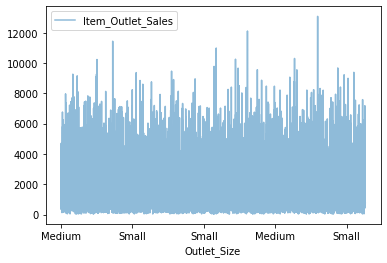

In [30]:
data.plot(kind='line', x='Outlet_Size', y='Item_Outlet_Sales', alpha=1.5,fig=(4,5))

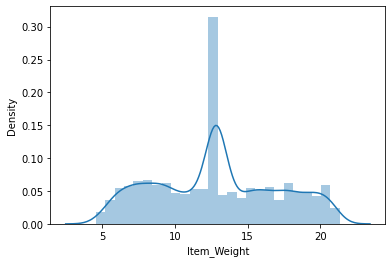

In [31]:
#univariate distribution of item weight
sns.distplot(data['Item_Weight'])

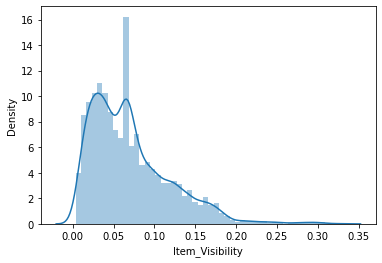

In [32]:
#Univariate distribution of item visibility
sns.distplot(data['Item_Visibility'])

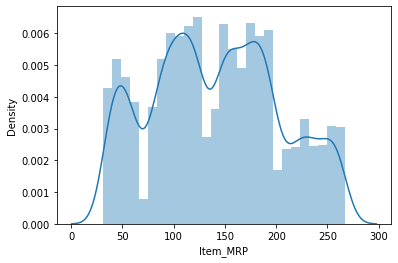

In [33]:
#Univariate distribution of price
sns.distplot(data['Item_MRP'])

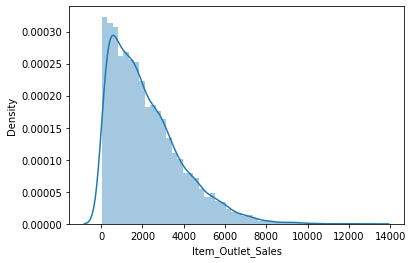

In [34]:
#univariate distribution of item outlet sales
sns.distplot(data['Item_Outlet_Sales'])

In [35]:
# log transformation of item outlet sales
data['Item_Outlet_Sales'] = np.log(1+data['Item_Outlet_Sales'])

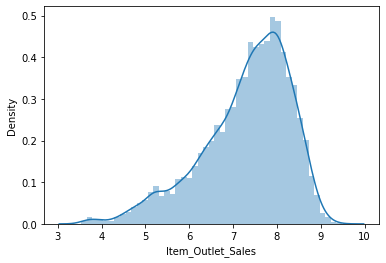

In [36]:
sns.distplot(data['Item_Outlet_Sales'])

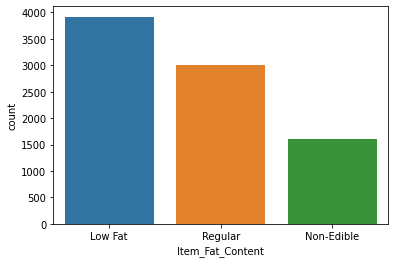

In [37]:
#Display count of items in each category
sns.countplot(data["Item_Fat_Content"])

[Text(0, 0, 'Food'), Text(0, 0, 'Drinks'), Text(0, 0, 'Non-Consumable')]

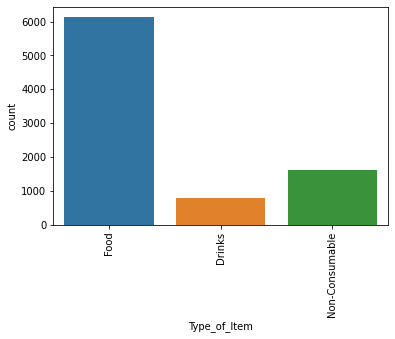

In [38]:
#Display of count of items
l = list(data['Type_of_Item'].unique())
chart = sns.countplot(data["Type_of_Item"])
chart.set_xticklabels(labels=l, rotation=90)

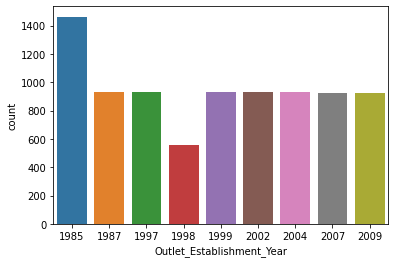

In [39]:
#Display count of outlets establised per year
sns.countplot(data['Outlet_Establishment_Year'])

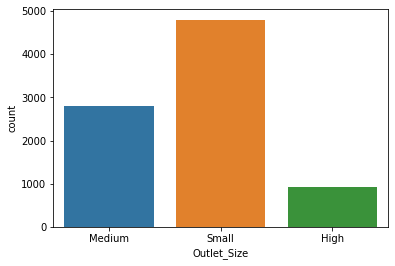

In [40]:
#Display of count of outlet size
sns.countplot(data['Outlet_Size'])

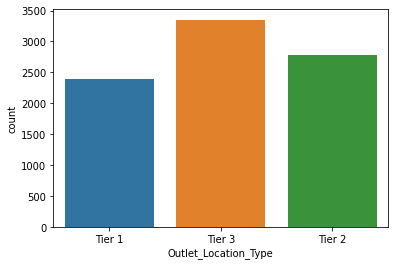

In [41]:
#Display of count of outlet location type
sns.countplot(data['Outlet_Location_Type'])

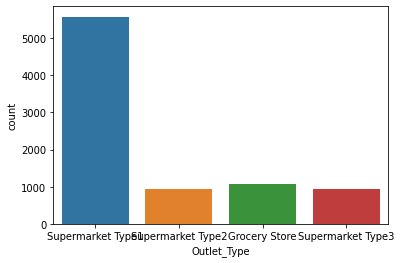

In [42]:
#Display count of outlet type
sns.countplot(data['Outlet_Type'])

## Correlation Matrix



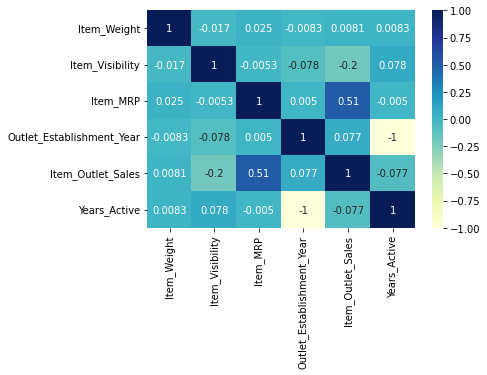

In [43]:
corr = data.corr()
sns.heatmap(corr, annot=True,cmap="YlGnBu")

## Encoding categorical variables into Numerical

In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Type_of_Item']
for col in cat_col:
    data[col] = le.fit_transform(data[col])

## Onehot Encoding the Numerical Variables

In [45]:
data = pd.get_dummies(data, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Type_of_Item'])


## Drop Unnecessary columns

In [46]:
X = data.drop(columns=['Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
y = data['Item_Outlet_Sales']

## Split Data into Training and Testing

In [47]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.50)

## Linear Regression

In [48]:
clf = LinearRegression()
clf.fit(Xtr,ytr)
yhat=clf.predict(Xts)
MSE_L=mean_squared_error(yts,yhat)
print("MSE of Linear Regression:",MSE_L)
LR=clf.score(X, y)
print("R Square score:",clf.score(X, y))
# clf.intercept_,clf.coef_, clf.score(X, y)

MSE of Linear Regression: 0.29192977265491127
R Square score: 0.7201820499203497


## Ridge Regression

In [49]:
ridge= Ridge(alpha=1)
ridge.fit(Xtr,ytr)
yhat=ridge.predict(Xts)
rsq = r2_score(yts, yhat)
MSE_R=mean_squared_error(yts,yhat)
print("MSE of Ridge Regression:",MSE_R)
print('Test R^2     = %f' % rsq)

MSE of Ridge Regression: 0.29222870664209133
Test R^2     = 0.712913


## Lasso Regression

In [50]:
reg = Lasso(alpha=1)
reg.fit(Xtr, ytr)
yhat1 = reg.predict(Xts)
rsq = r2_score(yts, yhat1)
MSE_LA=mean_squared_error(yts,yhat1)
print("MSE of Lasso Regression:",MSE_LA)
print('Test R^2= %f' % rsq)

MSE of Lasso Regression: 0.768319203088075
Test R^2= 0.245198


##Decision Trees

MSE of Decision Trees 0.5710254653177707
R Square score: 1.0


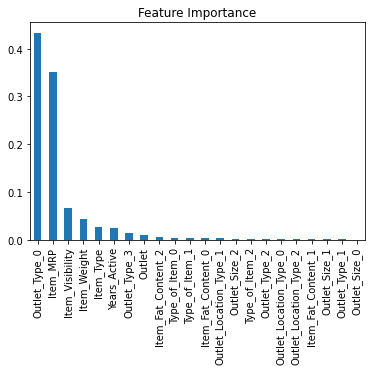

In [51]:
model = DecisionTreeRegressor()
model.fit(Xtr, ytr)
yhat= model.predict(Xts)
MSE_DT=mean_squared_error(yts,yhat)
print("MSE of Decision Trees",MSE_DT)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")
DT=model.score(Xtr, ytr)
print("R Square score:",model.score(Xtr, ytr))

##Random Forest

MSE of Random Forest: 0.3033229143669142
R Square score: 0.9589942111626157


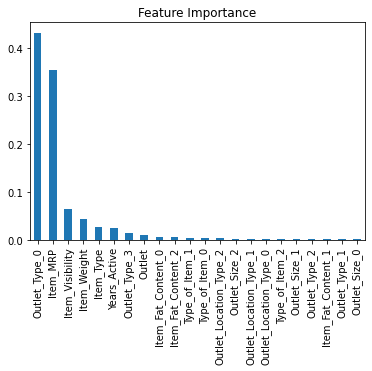

In [52]:
model = RandomForestRegressor()
model.fit(Xtr,ytr)
yhat=model.predict(Xts)
MSE_RF=mean_squared_error(yts,yhat)
coef = pd.Series(model.feature_importances_, Xtr.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")
RF=model.score(Xtr, ytr)
print("MSE of Random Forest:",MSE_RF)
print("R Square score:",model.score(Xtr, ytr))

## Extra Trees Regressor

MSE: 0.323739144587211
R Square score: 1.0


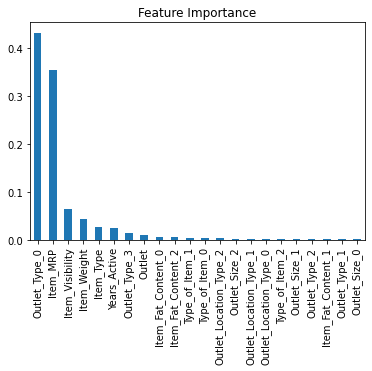

In [53]:
Extra = ExtraTreesRegressor()
Extra.fit(Xtr,ytr)
yhat=Extra.predict(Xts)
MSE_ET=mean_squared_error(yts,yhat)
coef = pd.Series(model.feature_importances_, Xtr.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")
ET=Extra.score(Xtr, ytr)
print("MSE:",MSE_ET)
print("R Square score:",Extra.score(Xtr, ytr))

## Neural Networks

In [54]:
#Construct the Neural Network
NN_model = Sequential()

NN_model.add(Dense(128, kernel_initializer='normal',input_dim = Xtr.shape[1], activation='relu',name='Input'))


NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='hidden'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='hidden1'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='hidden2'))

NN_model.add(Dense(1, kernel_initializer='normal',activation='linear',name='output'))


NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 128)               2944      
                                                                 
 hidden (Dense)              (None, 256)               33024     
                                                                 
 hidden1 (Dense)             (None, 256)               65792     
                                                                 
 hidden2 (Dense)             (None, 256)               65792     
                                                                 
 output (Dense)              (None, 1)                 257       
                                                                 
Total params: 167,809
Trainable params: 167,809
Non-trainable params: 0
_________________________________________________________________


In [55]:
#Save the model with the Best validation loss
checkpoint_name = 'Best_model.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [56]:
#Fit the model
NN_model.fit(Xtr,ytr,epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/100
102/107 [===========================>..] - ETA: 0s - loss: 1.3650 - mean_absolute_error: 1.3650
Epoch 1: val_loss improved from inf to 1.12855, saving model to Best_model.hdf5
107/107 [==============================] - 3s 14ms/step - loss: 1.3425 - mean_absolute_error: 1.3425 - val_loss: 1.1285 - val_mean_absolute_error: 1.1285
Epoch 2/100
102/107 [===========================>..] - ETA: 0s - loss: 0.7558 - mean_absolute_error: 0.7558
Epoch 2: val_loss improved from 1.12855 to 0.58414, saving model to Best_model.hdf5
107/107 [==============================] - 1s 10ms/step - loss: 0.7518 - mean_absolute_error: 0.7518 - val_loss: 0.5841 - val_mean_absolute_error: 0.5841
Epoch 3/100
102/107 [===========================>..] - ETA: 0s - loss: 0.5611 - mean_absolute_error: 0.5611
Epoch 3: val_loss did not improve from 0.58414
107/107 [==============================] - 1s 9ms/step - loss: 0.5657 - mean_absolute_error: 0.5657 - val_loss: 0.7479 - val_mean_absolute_error: 0.7479
Epoc

In [57]:
#Load the best model
Best_weights = 'Best_model.hdf5' 
NN_model.load_weights(Best_weights) 
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [58]:
#Predict the values
yhat = NN_model.predict(Xts)

In [59]:
MSE_NN=mean_squared_error(yts,yhat)
print("MSE of Neural Networks :",MSE_NN)

MSE of Neural Networks : 0.2840210788153105


## XG Boost

In [60]:
XGBModel = XGBRegressor()
XGBModel.fit(Xtr,ytr , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(Xts)
MSE_XGB=mean_squared_error(yts,XGBpredictions)
XG=XGBModel.score(Xtr, ytr)
print("MSE of XGB :",MSE_XGB)
print("R Square score:",XGBModel.score(Xtr, ytr))

[01:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE of XGB : 0.2744893327179807
R Square score: 0.7693738510457455


In [61]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Ridge','Lasso','Random Forest','Decision Tree','Neural Networks','XGB','Extra Trees'],
    
    'Score': [MSE_L,MSE_R,MSE_LA,MSE_RF,MSE_DT,MSE_NN,MSE_XGB,MSE_ET]
    })

models.sort_values(by='Score', ascending=True)

,Model,Score
6,XGB,0.274489
5,Neural Networks,0.284021
0,Linear Regression,0.291930
1,Ridge,0.292229
3,Random Forest,0.303323
7,Extra Trees,0.323739
4,Decision Tree,0.571025
2,Lasso,0.768319


In [63]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree','XGB','Extra Trees'],
    
    'R Square Score': [LR,RF,DT,XG,ET]
    })

models.sort_values(by='R Square Score', ascending=True)

,Model,R Square Score
0,Linear Regression,0.720182
3,XGB,0.769374
1,Random Forest,0.958994
2,Decision Tree,1.000000
4,Extra Trees,1.000000


In [64]:
# "---------------------------------------------THE END--------------------------------------"